# Shift Registers

Once we get down to symbol/bit level, there are a variety of uses for various forms of shift registers.

Usually these are some form of [Linear Feedback Shift Register](https://en.wikipedia.org/wiki/Linear-feedback_shift_register), and are used for things like:

- Cyclic Redundancy Checks, basically checksums to see if you've received a packet correctly
- Data "Whitening," i.e. random-ish bits deterministically mixed with the packed to ensure there aren't long strings of ones and zeros
- Pseudorandom Test Signals

In [7]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from alldigitalradio.io.numpy import make_callable, take_n
from alldigitalradio.shiftregisters import prbs9, GaloisCRC, LinearFeedbackShiftRegister
from alldigitalradio.util import unpack_mem

# CRC

CRC checksums are everywhere. While they're pretty simple, it can be quite confusing how to set one up correctly for a particular protocol (i.e. what is the CRC initialized to? how are the "taps" defined, etc). 

Given the inherently random looking nature of shift-register based components, it's tricky to look at the behavior of one and intuitively assert its correctness. The easiest way I've found to debug these is to just test it against real data (i.e. bits captured from wireshark, paying close attention to endianness issues that flip bytes around)

In [9]:
crc = GaloisCRC(width=24, taps=[1, 3, 4, 6, 9, 10, 24], init=0x555555)
crc = make_callable(crc, inputs=[crc.input, crc.en], outputs=[crc.crc])

for i in range(24):
    out = crc(0, 1)
    print(unpack_mem([out], 24))

[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
[1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0]
[0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1]
[1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0]
[0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1]
[1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0]
[0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1]
[1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0]
[0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1]
[1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0]
[0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1]
[1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0]
[0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]
[1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0]
[0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0]
[0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1]
[1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0]
[0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1]
[1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1]


If you squint, you can see the bits shift to the right, while sometimes changing depending on the input

# LFSR

Next up, we have Linear Feedback Shift Registers as used for data whitening in bluetooth low energy. There's no specific input here, it just runs continuously (although you can reset it to the initial state).

In [12]:
lfsr = LinearFeedbackShiftRegister(taps=[0,4,7], init=(37 | (1 << 6)))
lfsr = make_callable(lfsr, inputs=[lfsr.run_strobe], outputs=[lfsr.output])

print(list(map(lfsr, [1]*16)))

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]


# PRBS (Pseudo Random Binary Sequences)

You can probably modify the LFSR to generate these, but I've only used them in simulation at the moment. There are a bunch of "standard" ones such as PRBS9 which is used in BLE for a fair number of things.

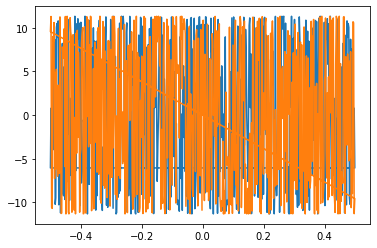

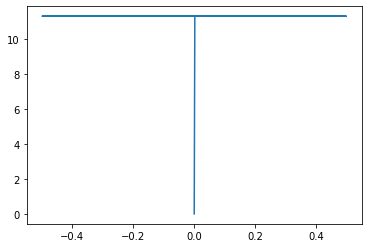

In [27]:
seq = prbs9()
seq -= np.mean(seq) # Remove DC offset since it blows up the axis of the fft

# Plot just the real part of the FFT
plt.plot(fftfreq(len(seq)), np.real(fft(seq)))
plt.plot(fftfreq(len(seq)), np.imag(fft(seq)))
plt.show()

# Now plot the magnitude...
plt.plot(fftfreq(len(seq)), np.abs(fft(seq)))
plt.show()

I was not expecting the noise to be as perfectly distributed as it is, hence why I've shown both the magnitude and the imaginary and real axis broken out